# ResNet 구현하기

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 모델의 깊이가 깊어질수록 성능 저하가 발생하는 'Degradation' 문제를 해결하기 위해 Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition 』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하였다. 데이터셋은 고양이, 개 이미지-레이블 쌍으로 구성된 데이터셋으로 학습 데이터 19,773개, 테스트 데이터 3,489개이다. 이미지를 모두 224 x 224로 리사이즈하고 Min-Max 정규화 전처리를 수행하였다. 'Plain-34', 'Plain-50', 'Res-34', 'Res-50' 네 개의 모델을 사용하였으며, 모두 배치 크기는 32로 설정하고 옵티마이저는 Adam을 사용하여 총 30회 학습하였다. 테스트 데이터셋에 대한 Epoch 30회 중 가장 낮은 손실값과 마지막 5회의 손실값 평균을 비교하였다. 학습 결과 테스트 데이터셋에 대한 30회 중 손실값은 'Resi-50`이 0.2257, 'Resi-34'가 0.2548, 'Plain-34'가 0.3163, 'Plain-50'이 0.6902 순으로 낮았다. 최종 5회의 손실값 평균 또한 해당 모델 순으로 낮음을 확인하였다. 나아가 'Plain-50' 모델의 학습 데이터셋에 대한 손실값과 테스트 데이터셋에 대한 손실값 변화 바탕으로, 두 데이터셋의 손실값 모두 특정 Epoch에서 더이상 감소하지 않은 것을 바탕으로 과적합이 원인이 아님을 확인하였다. 최종적으로 'Plain-50' 모델이 'Plain-34' 모델에 비해 층이 깊음에도 불구하고 손실값이 높은 것을 통해 'Degradation' 문제가 존재하였으며, 이를 'Deep Residual Learning' 기법을 적용한 'Res-34'와 'Res-50' 모델을 통해 해결할 수 있음을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 일반적으로 모델은 깊을수록 그 성능이 증가하는 것이 통념입니다. 하지만 특정 층 이상이 되면 오히려 성능이 감소하는 'Degradation' 문제가 발생합니다. 이는 과적합이 아닌 경사 소실 또는 폭발에 기인합니다. Kaiming He 외 3인은 해당 문제를 해결할 수 있는 방안으로 'Deep Residual Learning'을 제시하였습니다. 본 예제에서는 Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition
』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하고자 합니다. 
</span><br><br>

> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 Tensorflow에서 제공하는 고양이와 개 이미지 - 레이블 쌍으로 이루어진 'Cat_vs_dogs' 데이터셋 입니다. 학습 데이터 19,773개, 테스트 데이터 3,489개입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 고양이, 개 이미지 이며, 각 이미지의 크기가 상이하였습니다. 클래스의 경우 고양이가 0, 개가 1임을 확인하였습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출합니다.
***

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

import urllib3   #데이터셋 load
urllib3.disable_warnings()

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러옵니다.


+ Tensorflow에서 제공하는 고양이와 개 이미지-클래스로 이루어진 `cats_vs_dogs` 데이터셋을 사용합니다.
***

In [2]:
setattr(
    tfds.image_classification.cats_vs_dogs,
    '_URL',
    'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
)

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    data_dir='Y:/projects/gitProjects/aiffel_going_deeper_cv/dataset/gd_01/',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

<br>

#### 데이터셋 기본 정보 확인
***
+ 학습 데이터 19,773개, 테스트 데이터 3,489개 입니다.


+ 입력 데이터는 `int8` 형식의 사이즈가 다른 컬러 이미지입니다.


+ 클래스 레이블은 고양이가 0, 개가 1에 해당합니다.
***

In [3]:
train_size = tf.data.experimental.cardinality(ds_train).numpy()
test_size = tf.data.experimental.cardinality(ds_test).numpy()

print(f'DATA INFO'.center(80, '='))
print(f'Input Data: {ds_info.features["image"]}')
print(f'Target Data: {ds_info.features["label"]}')
print(f'\t└ Class info: {ds_info.features["label"].names}', end='\n\n')

print(f'Train Data Size: {train_size:,}')
print(f'Test Data Size: {test_size:,}')
print('='*80)

===================================DATA INFO====================================
Input Data: Image(shape=(None, None, 3), dtype=tf.uint8)
Target Data: ClassLabel(shape=(), dtype=tf.int64, num_classes=2)
	└ Class info: ['cat', 'dog']

Train Data Size: 19,773
Test Data Size: 3,489


<br>

#### 데이터셋 샘플 시각화
***
+ 데이터셋 이미지를 시각화 합니다.


+ 각 이미지의 사이즈가 상이한 것을 확인할 수 있습니다.


+ 또한 고양이는 0, 강아지는 1로 레이블링 되어있는 것을 확인할 수 있습니다.
***

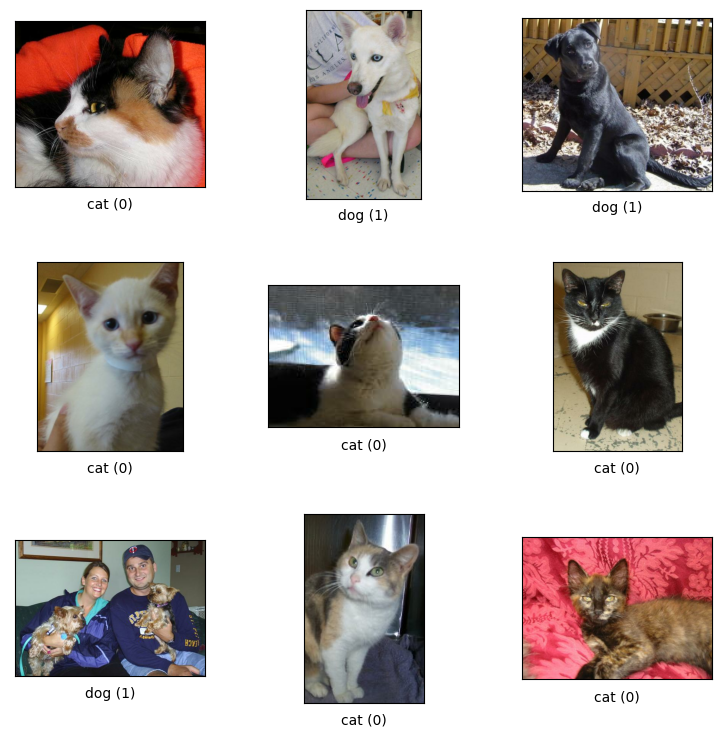

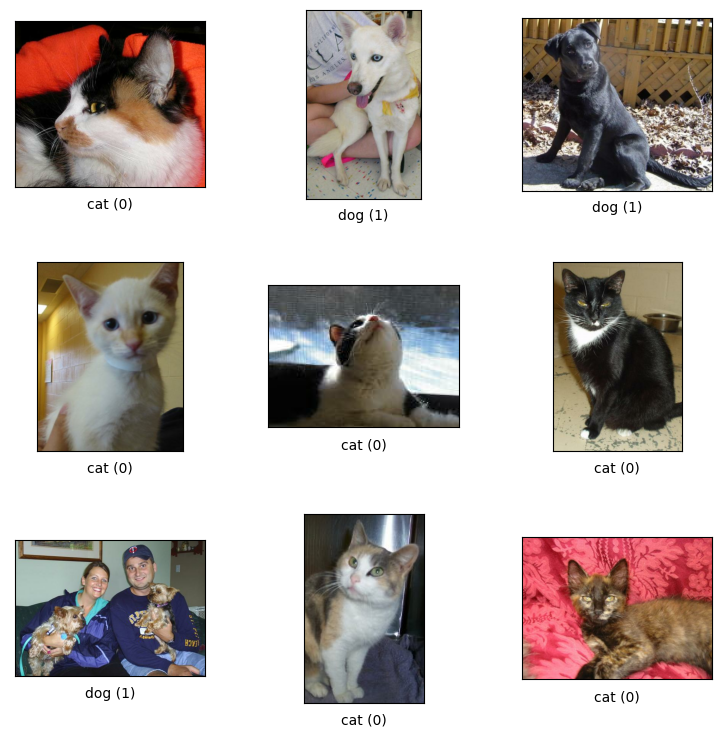

In [4]:
tfds.show_examples(ds_train, ds_info)

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞선 데이터 분석 단계에서 확인한 사항을 바탕으로 전처리를 수행합니다. 이미지 별 사이즈가 달랐으므로 모두 224 x 224 크기로 변환하여준 후 Min-Max 정규화를 수행합니다. 최종적으로 전처리 후 배치 사이즈 16으로 이루어진 데이터셋을 생성합니다.
</span>

***

#### 전처리 및 데이터셋 생성 함수 정의
***
+ 이미지 사이즈 변환 및 정규화 함수 `normalize_and_resize_img`와 데이터셋 생성 함수 `apply_normalize_on_dataset`를 정의합니다.
***

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<br>

#### 전처리 및 데이터셋 생성 수행
***
+ 학습 데이터와 테스트 데이터에 대한 전처리와 데이터셋 생성을 수행합니다.


+ 배치 사이즈는 GPU 메모리 크기를 고려하여 32로 설정 하였습니다.
***

In [6]:
BATCH_SIZE = 32

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

<br>

## 4. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 단순하게 층을 쌓은 'Plain' 모델과 'Residual' 모델을 생성합니다. 또한 각 층을 34, 50으로 구분하여 최종적으로 'Plain-34', 'Plain-50', 'Res-34', 'Res-50' 총 네 개의 모델을 생성하고 학습합니다. 배치 크기는 GPU 메모리 크기를 고려하여 32로 설정합니다. 옵티마이저는 'Adam'을 사용하여 총 30회 학습합니다.
</span>

***

#### 모델 생성 함수 정의
***
+ ResNet-34, ResNet-50 그리고 Plain 모델을 생성하는 `build_reset` 함수 정의합니다.
***

In [7]:
def build_reset(input_shape, is_50=False, is_resi=True):
    def ConvBlock(x, filters, kernel_size, strides=1, is_activation=True):
        out = K.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            activation=None
        )(x)
        out = K.layers.BatchNormalization()(out)
        if is_activation:
            out = K.layers.Activation(activation='ReLU')(out)
        return out
    
    def head_layer(x):
        out = ConvBlock(x, filters=64, kernel_size=7, strides=2, is_activation=True)
        out_up = K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(out)
        return out_up
    
    def res_block(x, filter_list, kernel_list, is_resi=True, short_cut=None, is_maxpool=False):
        out = x
        layer_size = len(kernel_list)
        for layer_idx in range(layer_size):
            filters = filter_list[layer_idx]
            kernel = kernel_list[layer_idx]
            
            is_last = True if (layer_idx + 1) == layer_size else False
            strides = 2 if layer_idx == 0 and is_maxpool else 1

            out = ConvBlock(out, filters=filters, kernel_size=kernel, is_activation=not is_last, strides=strides)
        
        if is_resi:
            if short_cut is not None:
                x = short_cut
            out = K.layers.Add()((out, x))
        out = K.layers.Activation(activation='ReLU')(out)
        return out

    def res_floor(x, filter_list, kernel_list, block_num, is_resi, short_strides=None):
        for block_idx in range(block_num):
            is_maxpool = False
            out_short = None
            if is_resi:
                if block_idx==0 and short_strides is not None:
                    last_filters = filter_list[-1]
                    out_short = ConvBlock(x, filters=last_filters, kernel_size=1, strides=short_strides, is_activation=False)
                    
                
            if block_idx==0 and short_strides==2:
                is_maxpool = True     
                
            x = res_block(
                x,
                filter_list=filter_list,
                kernel_list=kernel_list,
                is_resi=is_resi,
                short_cut=out_short,
                is_maxpool=is_maxpool
            )
        return x
    
    
    args = {
        'small': (
            ((3, 3), ) * 4, #kernel
            ((64, 64), (128, 128), (256, 256), (512, 512)), #filter
            (None, 2, 2, 2) #short_stride
        ),
        'big': (
            ((1, 3, 1), ) * 4,
            ((64, 64, 256), (128, 128, 512), (256, 256, 1024), (512, 512, 2048)),
            (1, 2, 2, 2)
        )
    }
    common_block_num_list = (3, 4, 6, 3)
    kernel_list, filter_list, short_stride_list = args['big'] if is_50 else args['small']
    args_iter = zip(filter_list, kernel_list, common_block_num_list, short_stride_list)
        
    
    input_layer = K.Input(shape=input_shape)
    out = head_layer(input_layer)
    
    for filter_li, kernel_li, block_num, short_stride in args_iter:
        out = res_floor(
            out,
            filter_list=filter_li,
            kernel_list=kernel_li,
            block_num=block_num,
            is_resi=is_resi,
            short_strides=short_stride
        )
    
    out = K.layers.AveragePooling2D(pool_size=2, padding='same')(out)
    out = K.layers.Flatten()(out)
    out = K.layers.Dense(units=2, activation='softmax')(out)

    model = K.models.Model(inputs=input_layer, outputs=out)
    return model

In [8]:
EPOCH = 30

<br>

### 4.1. ResNet-34
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ResNet-34 모델을 생성하고 'cats_vs_dogs' 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.0204, 최저는 0.0163입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.8874, 최저는 0.2548입니다. 데이터셋에 대한 정확도의 경우 최종 Epoch일 때가 가장 높았으며 0.9823입니다. 테스트 데이터셋에 대한 정확도는 최종 Epoch일 때 0.8846, 최고는 0.9217입니다.
   
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.0204|0.9823|
|**Best**|0.0163|0.9823|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.8874|0.8846|
|**Best**|0.2548|0.9217|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Resi-34 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [9]:
model = build_reset(input_shape=(224, 224, 3), is_50=False, is_resi=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

<br>

#### 모델 레이어 시각화
***
+ Resi-34 모델 구조를 시각화 합니다.
***

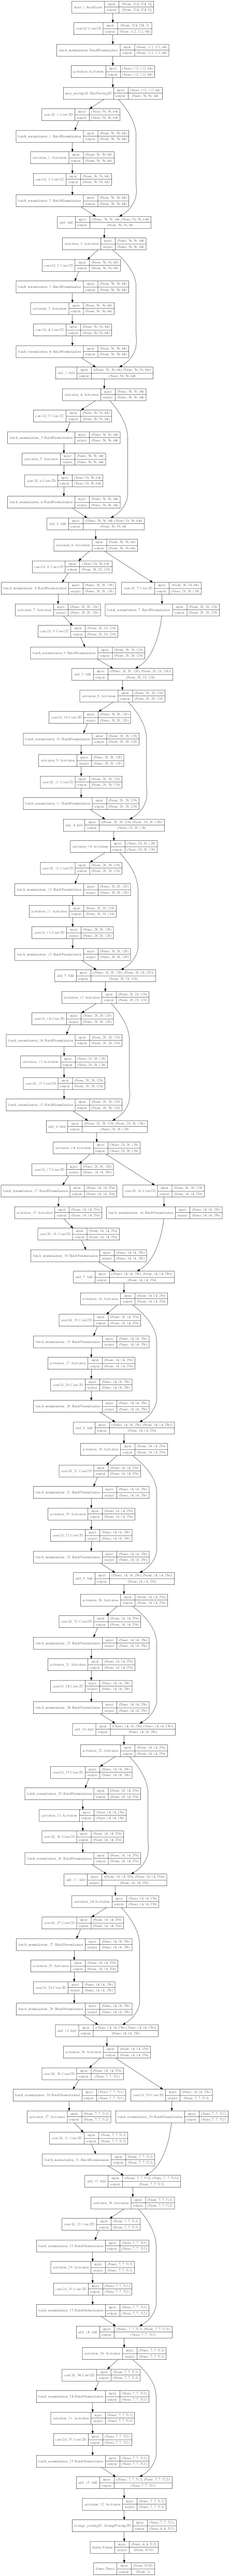

In [10]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Resi-34 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

res_34_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 47s - loss: 1.1838 - accuracy: 0.5376 - val_loss: 44.4338 - val_accuracy: 0.5094
Epoch 2/30
617/617 - 36s - loss: 0.7398 - accuracy: 0.5942 - val_loss: 0.7276 - val_accuracy: 0.5616
Epoch 3/30
617/617 - 36s - loss: 0.6036 - accuracy: 0.6787 - val_loss: 0.6636 - val_accuracy: 0.6535
Epoch 4/30
617/617 - 36s - loss: 0.5470 - accuracy: 0.7206 - val_loss: 0.6927 - val_accuracy: 0.6281
Epoch 5/30
617/617 - 36s - loss: 0.5154 - accuracy: 0.7444 - val_loss: 1.0474 - val_accuracy: 0.5542
Epoch 6/30
617/617 - 36s - loss: 0.4815 - accuracy: 0.7688 - val_loss: 0.7263 - val_accuracy: 0.5988
Epoch 7/30
617/617 - 36s - loss: 0.4444 - accuracy: 0.7894 - val_loss: 0.5149 - val_accuracy: 0.7530
Epoch 8/30
617/617 - 36s - loss: 0.3870 - accuracy: 0.8212 - val_loss: 0.4274 - val_accuracy: 0.8033
Epoch 9/30
617/617 - 37s - loss: 0.3390 - accuracy: 0.8501 - val_loss: 0.3852 - val_accuracy: 0.8533
Epoch 10/30
617/617 - 36s - loss: 0.2721 - accuracy: 0.8830 - val_loss: 0.4610 - val_accur

<br>

### 4.2. ResNet-50
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ResNet-50 모델을 생성, 학습하고 평가합니다. 마찬가지로 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.0491, 최저는 0.0313입니다. 정확도의 경우 최종 Epoch일 때 0.9835, 최고일 때 0.9881입니다.
    테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.2315, 최저는 0.2257입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.9306입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.0491|0.9835|
|**Best**|0.0313|0.9881|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.2315|0.9306|
|**Best**|0.2257|0.9306|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Resi-50 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [12]:
model = build_reset(input_shape=(224, 224, 3), is_50=True, is_resi=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

<br>

#### 모델 레이어 시각화
***
+ Resi-50 모델 구조를 시각화 합니다.
***

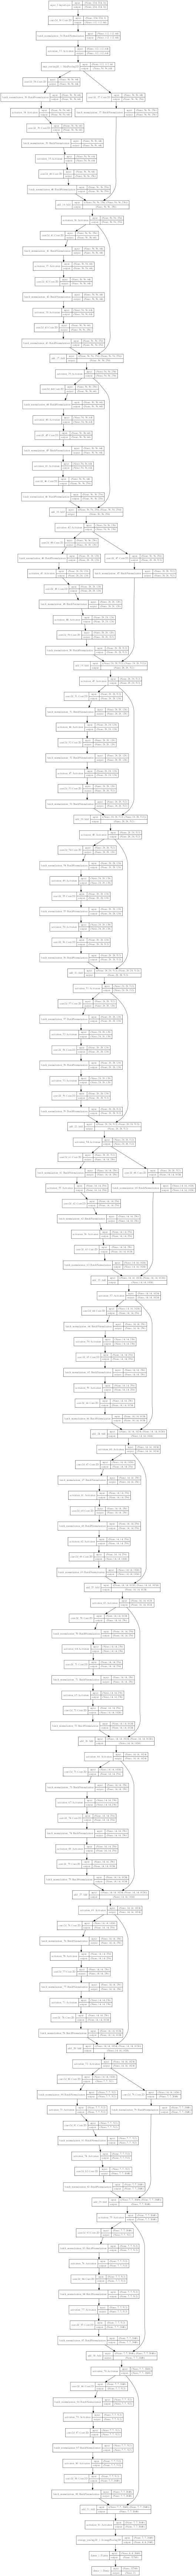

In [13]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Resi-50 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

res_50_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 66s - loss: 1.6098 - accuracy: 0.5285 - val_loss: 0.8755 - val_accuracy: 0.5430
Epoch 2/30
617/617 - 59s - loss: 0.7178 - accuracy: 0.6116 - val_loss: 0.6851 - val_accuracy: 0.6483
Epoch 3/30
617/617 - 58s - loss: 0.5857 - accuracy: 0.6919 - val_loss: 0.6491 - val_accuracy: 0.6979
Epoch 4/30
617/617 - 58s - loss: 0.5520 - accuracy: 0.7160 - val_loss: 0.9366 - val_accuracy: 0.5442
Epoch 5/30
617/617 - 58s - loss: 0.5286 - accuracy: 0.7355 - val_loss: 0.6278 - val_accuracy: 0.7035
Epoch 6/30
617/617 - 58s - loss: 0.4959 - accuracy: 0.7571 - val_loss: 0.6832 - val_accuracy: 0.6702
Epoch 7/30
617/617 - 58s - loss: 0.4574 - accuracy: 0.7866 - val_loss: 0.7525 - val_accuracy: 0.6963
Epoch 8/30
617/617 - 58s - loss: 0.4370 - accuracy: 0.7975 - val_loss: 0.8588 - val_accuracy: 0.6198
Epoch 9/30
617/617 - 58s - loss: 0.4149 - accuracy: 0.8091 - val_loss: 0.5558 - val_accuracy: 0.7197
Epoch 10/30
617/617 - 58s - loss: 0.4879 - accuracy: 0.7765 - val_loss: 0.7661 - val_accura

<br>

### 4.3. Plain-34
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Plain-34 모델을 생성, 학습하고 평가합니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때가 최저로 0.1616입니다. 정확도 또한 최종 Epoch일 때 가장 높았으며 0.9344입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.3683, 최저는 0.3163입니다. 정확도의 경우 최종 Epoch일 때 0.8574, 최고는 0.8819입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.1616|0.9344|
|**Best**|0.1616|0.9344|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.3683|0.8574|
|**Best**|0.3163|0.8819|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Plain-34 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [15]:
model = build_reset(input_shape=(224, 224, 3), is_50=False, is_resi=False)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256 

<br>

#### 모델 레이어 시각화
***
+ Plain-34 모델 구조를 시각화 합니다.
***

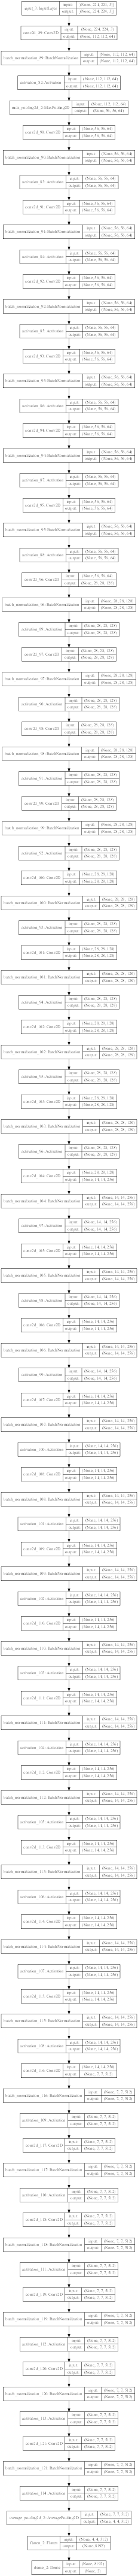

In [16]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Plain-34 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [17]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

plain_34_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 40s - loss: 0.8078 - accuracy: 0.4989 - val_loss: 0.9027 - val_accuracy: 0.5461
Epoch 2/30
617/617 - 34s - loss: 0.7105 - accuracy: 0.5112 - val_loss: 0.6956 - val_accuracy: 0.4987
Epoch 3/30
617/617 - 34s - loss: 0.6976 - accuracy: 0.5234 - val_loss: 0.7029 - val_accuracy: 0.4937
Epoch 4/30
617/617 - 34s - loss: 0.6883 - accuracy: 0.5532 - val_loss: 0.6883 - val_accuracy: 0.5545
Epoch 5/30
617/617 - 34s - loss: 0.6846 - accuracy: 0.5662 - val_loss: 0.7090 - val_accuracy: 0.5708
Epoch 6/30
617/617 - 34s - loss: 0.6721 - accuracy: 0.5947 - val_loss: 0.7067 - val_accuracy: 0.5258
Epoch 7/30
617/617 - 34s - loss: 0.6580 - accuracy: 0.6096 - val_loss: 0.9394 - val_accuracy: 0.5496
Epoch 8/30
617/617 - 34s - loss: 0.6484 - accuracy: 0.6268 - val_loss: 0.6936 - val_accuracy: 0.5916
Epoch 9/30
617/617 - 34s - loss: 0.6440 - accuracy: 0.6319 - val_loss: 1.6357 - val_accuracy: 0.5779
Epoch 10/30
617/617 - 34s - loss: 0.6359 - accuracy: 0.6403 - val_loss: 1.0078 - val_accura

<br>

### 4.3. Plain-50
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Plain-50 모델을 생성, 학습하고 평가합니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 가장 낮았으며 0.6810입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.5709입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 가장 낮았으며  0.6902입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.5496입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.6810|0.5709|
|**Best**|0.6810|0.5709|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.6902|0.5496|
|**Best**|0.6902|0.5496|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Plain-50 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [18]:
model = build_reset(input_shape=(224, 224, 3), is_50=True, is_resi=False)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256 

<br>

#### 모델 레이어 시각화
***
+ Plain-50 모델 구조를 시각화 합니다.
***

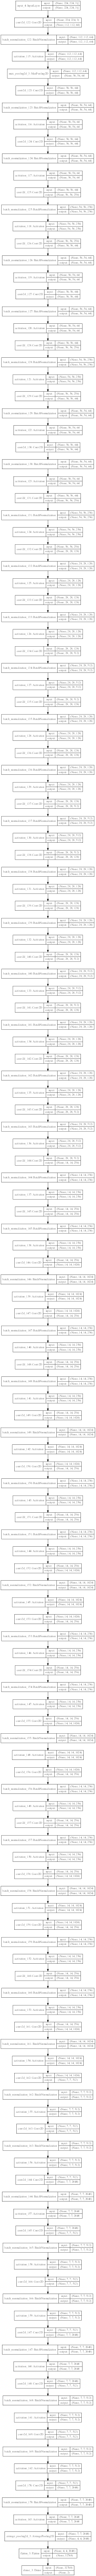

In [19]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Plain-50 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [20]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

plain_50_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 58s - loss: 1.0532 - accuracy: 0.5072 - val_loss: 11051.1758 - val_accuracy: 0.4942
Epoch 2/30
617/617 - 51s - loss: 0.7748 - accuracy: 0.5066 - val_loss: 0.8684 - val_accuracy: 0.5029
Epoch 3/30
617/617 - 51s - loss: 0.7576 - accuracy: 0.5071 - val_loss: 0.6947 - val_accuracy: 0.4903
Epoch 4/30
617/617 - 52s - loss: 0.7110 - accuracy: 0.4985 - val_loss: 0.6947 - val_accuracy: 0.5034
Epoch 5/30
617/617 - 51s - loss: 0.7009 - accuracy: 0.5028 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 6/30
617/617 - 51s - loss: 0.7002 - accuracy: 0.5078 - val_loss: 0.7031 - val_accuracy: 0.4968
Epoch 7/30
617/617 - 51s - loss: 0.6973 - accuracy: 0.4997 - val_loss: 0.6990 - val_accuracy: 0.4886
Epoch 8/30
617/617 - 51s - loss: 0.6950 - accuracy: 0.4964 - val_loss: 0.6961 - val_accuracy: 0.4796
Epoch 9/30
617/617 - 51s - loss: 0.6943 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 10/30
617/617 - 51s - loss: 0.6941 - accuracy: 0.5011 - val_loss: 0.6967 - val_ac

<br>

### 4.4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터셋에 대한 각 모델의 손실값과 정확도를 비교한 결과, 'Resi-50`, 'Resi-34', 'Plain-34', 'Plain-50' 모델 순으로 성능이 높음을 확인하였습니다. 주목할 점은 'Plain-50' 모델이 'Plain-34' 모델에 비해 더 깊은 층을 가지고 있음에도 불구하고 성능이 좋지 않다는 것입니다. 우선 이는 과적합으로 인해 발생한 것이 아닌데, 다음의 '학습 히스토리 시각화'에 제시된 그래프에 의하면, 학습 데이터셋에 대한 'Plain-50'의 손실값 또한 특정 시점에서 더이상 감소하지 않기 때문에, 과적합 상황에서 발생하는 형태인 학습 데이터의 손실값은 지속적으로 감소하지만 검증 데이터셋 에대한 손실값은 상승하는 형태와는 다르다는 점에서 그 원인이 과적합에 있지 않다고 할 수 있습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'Residual Model'을 제시한 Kaiming He 외 3인은 이와 같이 모델의 깊이가 깊어질수록 정확도가 감소하는 문제인 'Degradation'의 원인은 모델이 깊어질수록 경사가 소멸하거나 폭발하는 데에 있다고 지적하였습니다[1]. 그리고 이러한 문제를 해결하기 위해 중요한 특징(Identity Mapping)을 깊은 층에 전달하는 방식인 'Deep Residual Learning'을 제시하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이러한 내용을 바탕으로 데스트 데이터셋에 대한 각 모델의 손실값과 정확도를 확인하였을 때, 'Plain-34'에 비해 'Plain-50'의 성능 하락은 'degradation' 문제에 기반한 것이라 할 수 있습니다. 나아가 'Deep Residual Learning'을 사용한 'Res-34', 'Res-50' 모델에서 해당 문제를 해결하고 그 성능이 상승한 것을 확인할 수 있습니다.
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 손실값></b></center>

|TEST Loss|Res-34|Res-50|Plain-34|Plain-50|
|:---:|:---:|:---:|:---:|:---:|
|**BEST**|0.2548|**<span style="color:red">0.2257<span>**|0.3163|0.6902|
|**LAST 5 AVERAGE**|0.5075|**<span style="color:red">0.3188<span>**|0.5106|0.7759|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 정확도></b></center>

|TEST Loss|Res-34|Res-50|Plain-34|Plain-50|
|:---:|:---:|:---:|:---:|:---:|
|**BEST**|0.9217|**<span style="color:red">0.9306<span>**|0.8819|0.5496|
|**LAST 5 AVERAGE**|0.8936|**<span style="color:red">0.9010<span>**|0.8348|0.5116|

<br>
    
***

<br>

#### 학습 히스토리 시각화
***
+ 학습 데이터셋과 테스트 데이터셋에 대한 손실값과 정확도를 보여주는 학습 히스토리를 시각화 합니다.
***

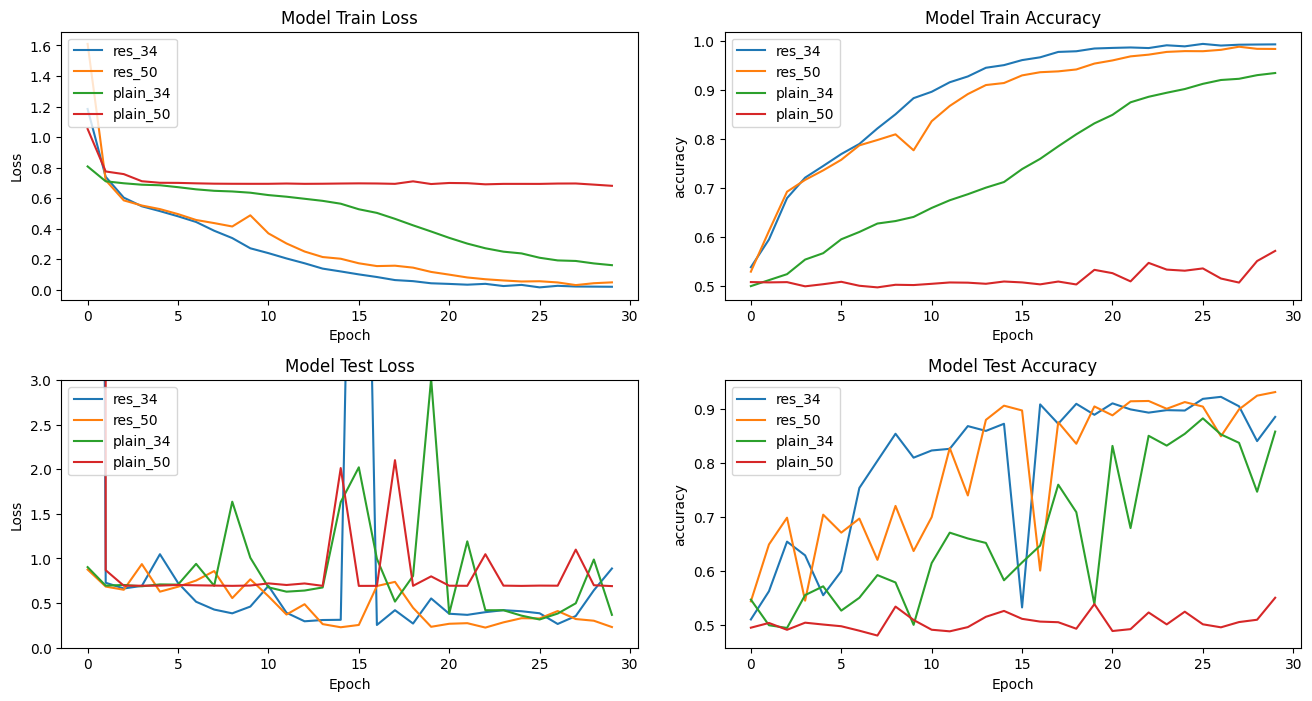

In [24]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.30)

plt.subplot(2, 2, 1)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['loss'])
plt.title('Model Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 2)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['accuracy'])
plt.title('Model Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 3)
plt.ylim(0, 3.0)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['val_loss'])
plt.title('Model Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 4)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['val_accuracy'])
plt.title('Model Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.show()

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp;  Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition 』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하였습니다. 확인 결과 단순히 층만을 쌓은 'Plain-34'와 'Plain-50' 모델을 비교하였을 때, 더 깊은 모델인 'Plain-50'의 손실값이 더 높았습니다. 또한, 'Plain-50' 모델의 학습 데이터셋에 대한 손실값과 테스트 데이터셋에 대한 손실값 모두 더이상 감소하지 않는다는 점에서 이는 과적합이 아님을 확인하였습니다. 나아가 'Plain' 모델과 'Residual' 모델의 성능을 비교하였을 때, 'Residual' 모델의 경우가 더 좋았습니다. 또한, 더 깊은 'Res-50' 모델이 'Res-34' 모델에 비해 성능이 좋았으므로 'Deep Residual Learning'을 통해 'Degradation' 문제를 해결하였다고 할 수 있습니다.
</span>

***

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

#### 형상관리 기록
***
+ v1_1: 초기 예제


+ v1_2: Epoch 조절
***